In [ ]:
%env CUDA_VISIBLE_DEVICES=1

### Renaming "_numnodes_9"

In [ ]:
import os
from pathlib import Path

def rename_files(root_dir):
    # Walk through all directories and files
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if '_numnodes_9_' in filename:
                old_path = os.path.join(dirpath, filename)
                new_filename = filename.replace('_numnodes_9_', '_numnodes_10_')
                new_path = os.path.join(dirpath, new_filename)
                os.rename(old_path, new_path)
                print(f"Renamed: {old_path} -> {new_path}")

# Run the renaming starting from current directory
rename_files('exp')


### Explore amount of formats per task/experiment

In [23]:
import json
from pathlib import Path

path = Path("exp/Llama-3.2-1B-Instruct_lora---simpleanswers-no-chat-template")

def load_json(path):
    with open(path, "r") as f:
        return json.load(f)

formats_evaluated_per_task = []
task_names = []

for filename in sorted(path.glob("*.json")):
    file = load_json(filename)
    n_formats_evaluated = len(file["all_structured_prompt_formats_accuracies"])
    formats_evaluated_per_task.append(n_formats_evaluated)
    tasknum = [part for part in filename.stem.split("_") if "task" in part][0]
    task_names.append(tasknum)

In [ ]:
splits_path = Path("train_test_splits/random")

for filename in sorted(splits_path.glob("*.json")):
    file = load_json(filename)
    tasknum = [part for part in filename.stem.split("_") if "task" in part][0]
    print(tasknum, len(file["test_formats"]))

In [ ]:
from collections import Counter

Counter(formats_evaluated_per_task)

In [ ]:
for n, task in zip(formats_evaluated_per_task, task_names):
    print(task, n)

### Explore class balance in Natural Instructions

In [1]:
import json
from math import log
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 6)
%config InlineBackend.figure_format = "svg"

from generate_train_val_test_formats import TASK_NAMES

/home/seleznev/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

task_names = set(TASK_NAMES)

def load_json(path):
    with open(path, "r") as f:
        return json.load(f)

answer_counters = []

for path in Path("../natural-instructions/tasks/").glob("*.json"):
    task_num = str(path.stem).split('_')[0]
    if task_num not in task_names:
        continue

    task = load_json(path)

    answers = []
    for instance in task["Instances"]:
        assert isinstance(instance["output"], list) and len(instance["output"]) == 1, f"{path}\n{instance['output']}"
        answers.append(instance["output"][0])

    answer_counters.append(Counter(answers))

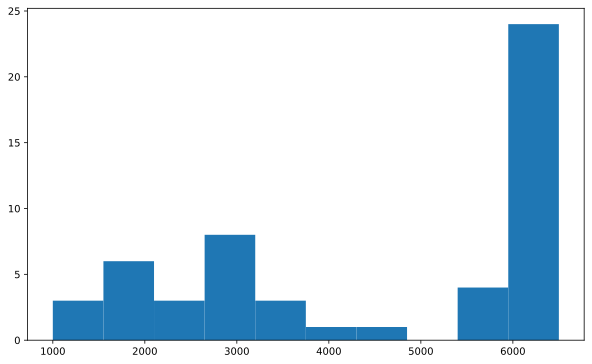

In [4]:
task_sizes = [sum(counter.values()) for counter in answer_counters]

plt.hist(task_sizes)
plt.show()

In [5]:
sorted(task_sizes)

[1000,
 1193,
 1500,
 1731,
 1777,
 1800,
 1883,
 1883,
 2047,
 2270,
 2476,
 2621,
 2855,
 2925,
 2946,
 2997,
 2997,
 3000,
 3009,
 3169,
 3708,
 3716,
 3728,
 3975,
 4471,
 5527,
 5565,
 5761,
 5912,
 5985,
 6213,
 6356,
 6369,
 6384,
 6385,
 6417,
 6427,
 6440,
 6452,
 6490,
 6494,
 6499,
 6500,
 6500,
 6500,
 6500,
 6500,
 6500,
 6500,
 6500,
 6500,
 6500,
 6500]

In [3]:
def relative_entropy(counter):
    freqs = list(counter.values())
    probs = [f / sum(freqs) for f in freqs]
    n = len(probs)

    entropy = sum(-p * log(p) for p in probs)
    max_entropy = log(n)
    return entropy / max_entropy

In [4]:
balancedness = [relative_entropy(c) for c in answer_counters]

In [ ]:
plt.title("Class distribution entropy / (Maximal possible entropy)\nfor 53 tasks in Natural Instructions")
plt.scatter(range(len(balancedness)), balancedness)
plt.ylabel("Entropy / MaxEntropy")
plt.xlabel("Task index") 
plt.show()

### Exploring format structures for tasks

In [1]:
import json
from pathlib import Path

def load_json(filename):
    with open(filename, "r") as f:
        return json.load(f)

action_type_sequences = []

root_dir = Path("train_test_splits/random")
for filename in root_dir.glob("*"):
    config = load_json(filename)
    action_type_sequences.append(
        (str(filename), config["action_types"])
    )

In [ ]:
max(action_type_sequences, key=lambda x: len(x[1]))

In [4]:
full = [name_seq for name_seq in action_type_sequences if len(set(name_seq[1])) == 6]

In [ ]:
len(full)

In [ ]:
sorted(full, key=lambda name_seq: len(name_seq[1]))

### Checking dataset structure

In [ ]:
import pandas as pd

dataset = pd.read_csv("data/df_hermes_superclear.csv")

dataset.head()

### Checking answer probability aggregation

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

from utils import (
    _tokenize_prompts, 
    _tokenize_prompts_with_answers,
    get_ranking_based_generation_single_token_output_classes, 
    get_ranking_based_generation_multiple_token_output_classes
)

In [3]:
model_name = "unsloth/Llama-3.2-1B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
tokenizer("once upon a time...", add_special_tokens=False)["input_ids"]

In [ ]:
batch_size = 2
seq_len = 5
vocab_size = 128

logits = torch.arange(batch_size * seq_len * vocab_size).reshape(batch_size, seq_len, vocab_size).float()
logits = logits / logits.numel()
tokens = torch.randint(0, vocab_size, size=(batch_size, seq_len))

torch.gather(logits, dim=-1, index=tokens[..., None]).squeeze()

In [ ]:
manual = torch.empty(batch_size, seq_len)

for i in range(batch_size):
    for j in range(seq_len):
        manual[i, j] = logits[i, j, tokens[i, j]]

manual

In [ ]:
cumul_log_probs = torch.arange(2 * 3)

cumul_log_probs.reshape(2, 3)

In [ ]:
tokenizer.special_tokens_map

In [9]:
special_tokens_dict = {'pad_token': '<pad>'}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
tokenizer.padding_side = "left"

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    cache_dir="/disk/4tb/seleznev/.cache/huggingface",
    # local_files_only=True,
    torch_dtype=torch.bfloat16
).eval().cuda()

model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = tokenizer.pad_token_id
model.generation_config.pad_token_id = tokenizer.pad_token_id

### Checking single token ranking function

In [15]:
prompts = [
    "Question: 2+2 equals?\nChoose correct option: A) 3 B) 4 C) 5.\nRespond with a single letter.",
    "Question: Is an elephant heavier than a mouse?\nChoose correct option:  A) yes B) no C) sometimes.\nRespond with in a single letter.",
    "Question: A synonim for the word 'rapid'?\nChoose correct option:  A) slow B) fast C) rap.\nRespond with in a single letter."
]

output_classes = ["A", "B", "C"]

In [ ]:
generation = get_ranking_based_generation_single_token_output_classes(prompts, output_classes, tokenizer, model)

In [ ]:
generation

In [ ]:
prompt = "2 + 2 = "

out = model.generate(**tokenizer(prompt, return_tensors="pt").to("cuda"), max_new_tokens=10)

generations = tokenizer.batch_decode(out)

for g in generations:
    print(g)

In [ ]:
prompt = prompts[1]

input_ids = tokenizer.apply_chat_template(
    [{"role": "user", "content": prompt}], 
    return_tensors="pt"
).to("cuda")

out = model.generate(input_ids, max_new_tokens=10)

generations = tokenizer.batch_decode(out)

for g in generations:
    print(g)

### Checking multi-token ranking function

In [14]:
prompts = [
    "Question: 2+2 equals? Choose correct option.\nOption 1: 3 Option 2: 4 Option 3: 5.",
    "Question: Is an elephant heavier than a mouse? Choose correct option.\nOption 1: yes Option 2: no Option 3: sometimes.",
    "Question: A synonim for the word 'rapid'? Choose correct option.\nOption 1: slow Option 2: fast Option 3: rap."
]

output_classes = ["Option 1", "Option 2", "Option 3"]

In [ ]:
generation = get_ranking_based_generation_multiple_token_output_classes(prompts[0], output_classes, tokenizer, model, batch_size_llm=2)

In [ ]:
generation

### Checking chat templating

In [ ]:
tokenizer.chat_template

In [11]:
special_tokens_dict = {'pad_token': '<pad>'}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
tokenizer.padding_side = "left"

In [12]:
prompts = [
    "Q: Do pigs fly? (yes or no)\nA:",
    "Q: Is Everest higher than 9000 meters? (yes or no)\nA:",
    "Q: Is 2 + 2 = 4 correct? (yes or no):\nA:"
]

In [13]:
answers = ["yes", "no"]

In [14]:
inputs = _tokenize_prompts_with_answers(prompts, answers, tokenizer)

In [ ]:
inputs.input_ids.shape

In [ ]:
padded_text = tokenizer.batch_decode(inputs if isinstance(inputs, torch.Tensor) else inputs.input_ids)

for text in padded_text:
    print(text)
    print("="*30)